In [104]:
# Import packages

from __future__ import print_function, division
from IPython.display import display, HTML

import pandas as pd
import numpy as np

from tqdm import tqdm

# import statsmodels.api as sm
from statsmodels import tsa
import statsmodels.api as sm
from datetime import date, datetime, timedelta
import copy
import scipy as sp
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import interpolate
import datetime

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

# Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (20, 10) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# this allows plots to appear directly in the notebook
#%matplotlib inline

# pandas settings
pd.set_option('precision', 6)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# this allows plots to appear directly in the notebook
get_ipython().magic(u'matplotlib inline')


In [148]:
stock = pd.read_csv('apple+micro.csv', index_col=0, header=0)
stock['PERMNO'] = stock.index
stock['date'] = stock['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
stock = stock.reset_index(drop=True)
stock.head()

,date,SHRCD,EXCHCD,SICCD,COMNAM,NAICS,DCLRDT,PAYDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,CFACPR,PERMNO
0,1980-12-12,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-28.812500,nan,56.000000,14593
1,1980-12-15,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-27.312500,nan,56.000000,14593
2,1980-12-16,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-25.312500,nan,56.000000,14593
3,1980-12-17,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-25.937500,nan,56.000000,14593
4,1980-12-18,11,3,3573,APPLE COMPUTER INC,nan,nan,nan,nan,nan,nan,-26.687500,nan,56.000000,14593


In [142]:
apple = merge1[merge1['PERMNO'] == 14593]

In [143]:
apple.describe()

,date,EXCHCD,NAICS,PRC,VOL,PERMNO,key,DISTCD,DIVAMT,EXDT
count,9093.000000,9093.000000,3163.000000,9093.000000,8595.000000,9093.000000,9093.000000,53.000000,53.000000,53.000000
mean,19985204.548444,3.000000,334111.000000,97.261148,12208922.643979,14593.000000,1459319985204.548584,1232.000000,0.613208,19990307.849057
std,104069.602510,0.000000,0.000000,138.466823,16781264.999203,0.000000,104069.602510,0.000000,1.003127,112674.946316
min,19801212.000000,3.000000,334111.000000,-36.062500,96125.000000,14593.000000,1459319801212.000000,1232.000000,0.060000,19870511.000000
25%,19891208.000000,3.000000,334111.000000,25.875000,1399579.500000,14593.000000,1459319891208.000000,1232.000000,0.120000,19900820.000000
50%,19981207.000000,3.000000,334111.000000,42.750000,4064286.000000,14593.000000,1459319981207.000000,1232.000000,0.120000,19931119.000000
75%,20071220.000000,3.000000,334111.000000,100.000000,17753069.500000,14593.000000,1459320071220.000000,1232.000000,0.520000,20130808.000000
max,20161230.000000,3.000000,334111.000000,702.099980,189848621.000000,14593.000000,1459320161230.000000,1232.000000,3.290000,20161103.000000


In [5]:
# Drop missing values in terms of PERMNO, date, close price, and volume
merge1 = merge1.dropna(axis=0, subset=['PERMNO','date','PRC','VOL'])
merge1[['PERMNO','date','PRC','VOL']].isnull().values.any()

False

In [6]:
# Consider ordinary common shares trading on either the NYSE, AMEX, or NASDAQ 
# CRSP exchange codes 1, 2, and 3
merge1 = merge1[merge1['EXCHCD'].isin([1,2,3])]
merge1['EXCHCD'].unique()

array([ 3.,  2.,  1.])

In [7]:
# Consider all regular dividend events with CRSP distribution codes 1222, 1232, 1242, and 1252
merge1 = merge1[merge1['DISTCD'].apply(lambda x: np.isnan(x)) | merge1['DISTCD'].isin([1222, 1232, 1242, 1252])]
merge1['DISTCD'].unique()

array([   nan,  1232.,  1222.,  1252.,  1242.])

In [8]:
# Reset index 
merge1.index = pd.RangeIndex(len(merge1.index))
merge1.head()

,date,EXCHCD,TICKER,COMNAM,NAICS,PRC,VOL,PERMNO,key,DISTCD,DIVAMT,EXDT
0,19860107,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.562500,1000.000000,10000,1000019860107,nan,nan,nan
1,19860108,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,12800.000000,10000,1000019860108,nan,nan,nan
2,19860109,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,1400.000000,10000,1000019860109,nan,nan,nan
3,19860110,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,8500.000000,10000,1000019860110,nan,nan,nan
4,19860113,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.625000,5450.000000,10000,1000019860113,nan,nan,nan


In [9]:
DIVIDENDS = merge1[~merge1['DISTCD'].isnull()]
DIVIDENDS['DISTCD'].unique()

array([ 1232.,  1222.,  1252.,  1242.])

In [10]:
DIVIDENDS.head()

,date,EXCHCD,TICKER,COMNAM,NAICS,PRC,VOL,PERMNO,key,DISTCD,DIVAMT,EXDT
403,19860310,3.000000,GFGC,GREAT FALLS GAS CO,nan,-6.250000,100.000000,10001,1000119860310,1232.000000,0.095000,19860310.000000
466,19860609,3.000000,GFGC,GREAT FALLS GAS CO,nan,-6.187500,1050.000000,10001,1000119860609,1232.000000,0.105000,19860609.000000
529,19860908,3.000000,GFGC,GREAT FALLS GAS CO,nan,6.750000,1610.000000,10001,1000119860908,1232.000000,0.105000,19860908.000000
593,19861208,3.000000,GFGC,GREAT FALLS GAS CO,nan,6.500000,400.000000,10001,1000119861208,1232.000000,0.105000,19861208.000000
655,19870309,3.000000,GFGC,GREAT FALLS GAS CO,nan,6.125000,650.000000,10001,1000119870309,1232.000000,0.105000,19870309.000000


In [96]:
DIVIDENDS['PERMNO'].unique()

array([10001, 10002, 10003, ..., 19676, 19692, 19713])

In [113]:
stock1 = merge1[merge1['PERMNO'] == 10001]
stock1['Price'] = abs(stock1['PRC'])
stock1['date'] = stock1['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
stock1 = stock1[['date', 'Price', 'VOL', 'DIVAMT']]
stock1 = stock1.reset_index(drop=True)
stock1.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,Price,VOL,DIVAMT
0,1986-01-09,5.750000,14160.000000,nan
1,1986-01-10,5.875000,0.000000,nan
2,1986-01-13,5.875000,2805.000000,nan
3,1986-01-14,5.875000,2070.000000,nan
4,1986-01-15,6.062500,6000.000000,nan


In [114]:
dividend1 = stock1[~stock['DIVAMT'].isnull()]
dividend1.head()

,date,Price,VOL,DIVAMT
41,1986-03-10,6.250000,100.000000,0.095000
104,1986-06-09,6.187500,1050.000000,0.105000
167,1986-09-08,6.750000,1610.000000,0.105000
231,1986-12-08,6.500000,400.000000,0.105000
293,1987-03-09,6.125000,650.000000,0.105000


In [78]:
dividend['Increase'] = dividend['DIVAMT']
dividend['Increase'].iloc[0] = 0
dividend['Increase'].iloc[1:] = np.diff(dividend['DIVAMT'])
dividend['Increase'] = dividend['Increase'] > 0
dividend

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

,date,Price,VOL,DIVAMT,Increase
41,19860310,6.250000,100.000000,0.095000,False
104,19860609,6.187500,1050.000000,0.105000,True
167,19860908,6.750000,1610.000000,0.105000,False
231,19861208,6.500000,400.000000,0.105000,False
293,19870309,6.125000,650.000000,0.105000,False
356,19870608,5.500000,600.000000,0.105000,False
419,19870904,6.000000,400.000000,0.105000,False
483,19871207,5.875000,2000.000000,0.105000,False
545,19880307,6.375000,0.000000,0.110000,True
609,19880607,6.250000,700.000000,0.110000,False


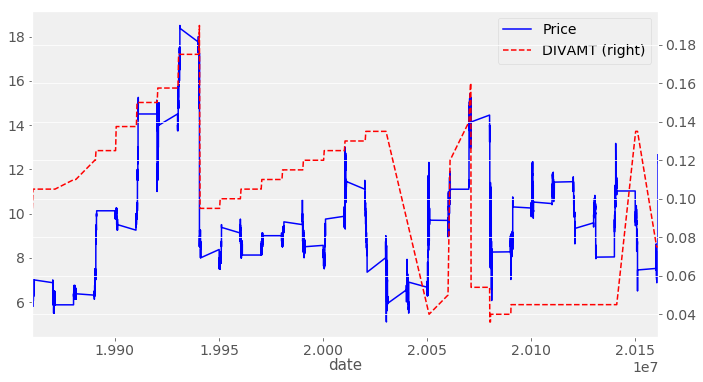

In [39]:
ax = stock.plot(kind='line', x='date', y='Price', color='Blue', figsize=(10,6))
dividend.plot(kind='line', x='date', y='DIVAMT', secondary_y=True, color='Red', style='--', ax=ax)

In [110]:
def Dividend_Period_Plot(df1, df2, increase=False):
    index = df2.index
    j = index[0]
    sample = df1.iloc[:j+1]
    ax = sample.plot(kind='line', x='date', y='Price', color='Blue', legend=False, figsize=(20,10))
    if increase:
        for i in tqdm(index[1:]):
            sample = df1.iloc[j:(i+1)]
            if sample['DIVAMT'].iloc[-1] > sample['DIVAMT'].iloc[0]:
                sample.plot(kind='line', x='date', y='Price', color='Red', legend=False, ax=ax)
            else:
                sample.plot(kind='line', x='date', y='Price', color='Blue', legend=False, ax=ax)
            j = i
    else:
        for i in tqdm(index[1:]):
            sample = df1.iloc[j:(i+1)]
            sample.plot(kind='line', x='date', y='Price', legend=False, ax=ax)
            j = i
    return

100%|██████████| 170/170 [00:01<00:00, 85.55it/s]


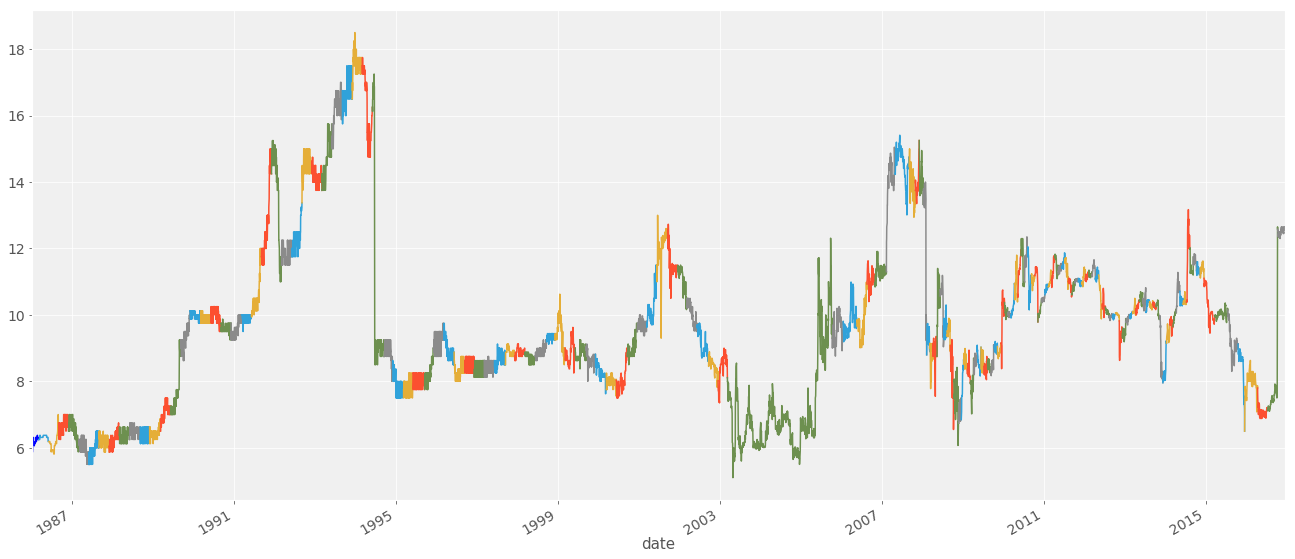

In [115]:
Dividend_Period_Plot(stock1, dividend1)

100%|██████████| 170/170 [00:02<00:00, 76.93it/s]


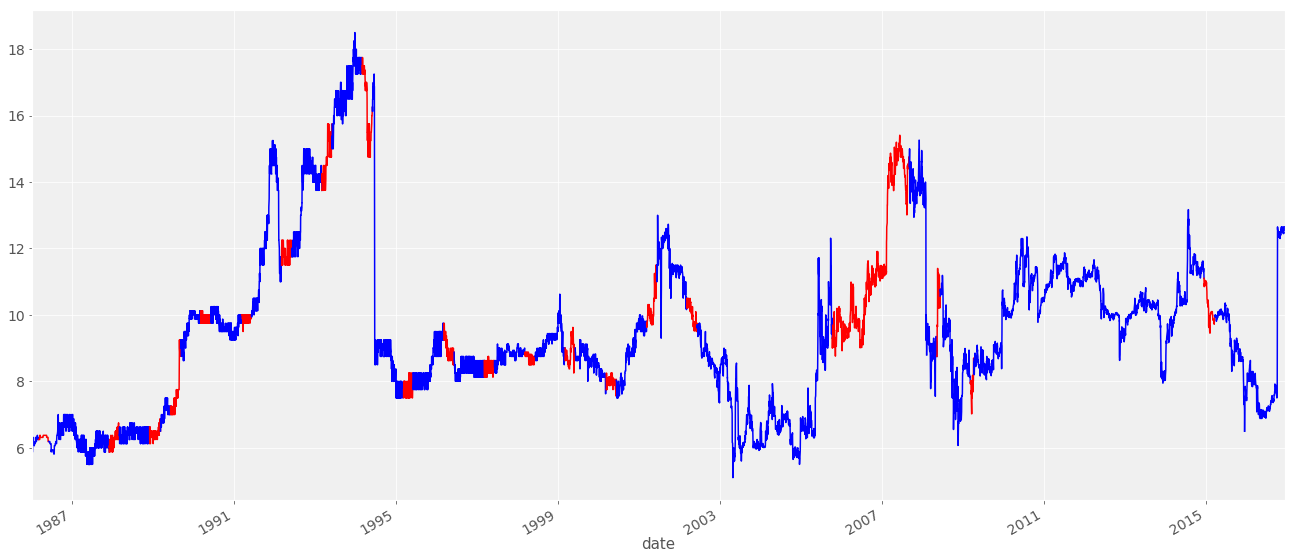

In [116]:
Dividend_Period_Plot(stock1, dividend1, increase=True)

In [108]:
stock2 = merge1[merge1['PERMNO'] == 10002]
stock2['Price'] = abs(stock2['PRC'])
stock2['date'] = stock2['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
stock2 = stock2[['date', 'Price', 'VOL', 'DIVAMT']]
stock2 = stock2.reset_index(drop=True)
stock2.head()

/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yunkunxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,Price,VOL,DIVAMT
0,1986-01-10,11.750000,40550.000000,nan
1,1986-01-13,11.437500,11300.000000,nan
2,1986-01-14,11.500000,6850.000000,nan
3,1986-01-15,11.312500,9100.000000,nan
4,1986-01-16,11.312500,16600.000000,nan


In [109]:
dividend2 = stock2[~stock2['DIVAMT'].isnull()]
dividend2.head()

,date,Price,VOL,DIVAMT
2007,1993-12-17,12.875000,0.000000,0.050000
2071,1994-03-21,13.125000,0.000000,0.060000
2128,1994-06-13,13.250000,0.000000,0.060000
2192,1994-09-13,12.500000,200.000000,0.070000
2256,1994-12-13,13.125000,0.000000,0.070000


100%|██████████| 62/62 [00:00<00:00, 75.59it/s]


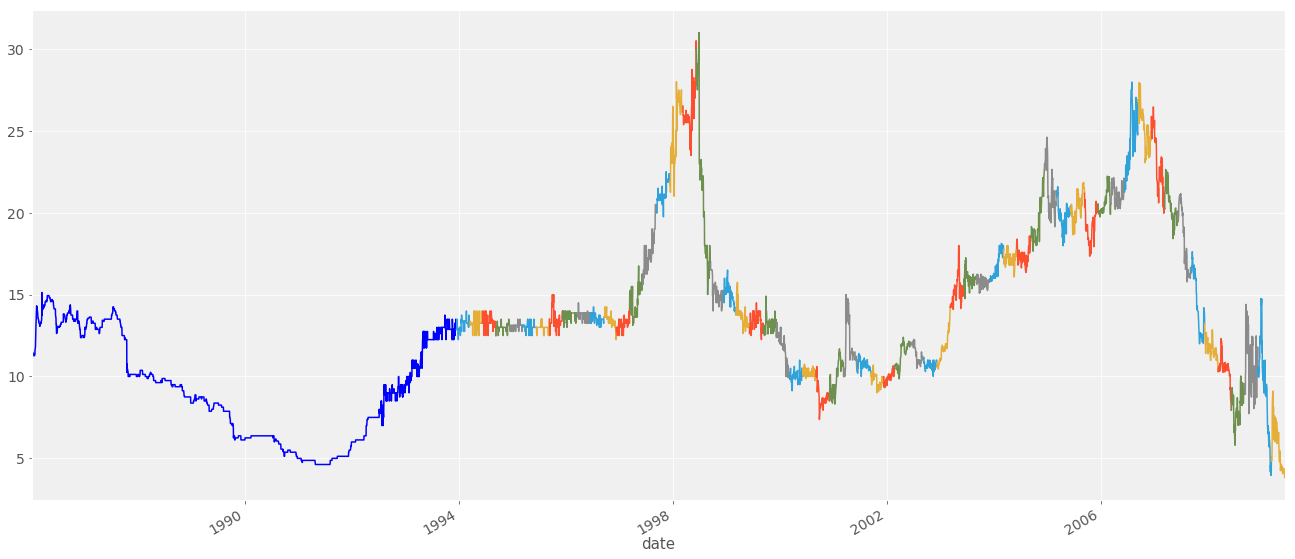

In [111]:
Dividend_Period_Plot(stock2, dividend2)

100%|██████████| 62/62 [00:00<00:00, 75.18it/s]


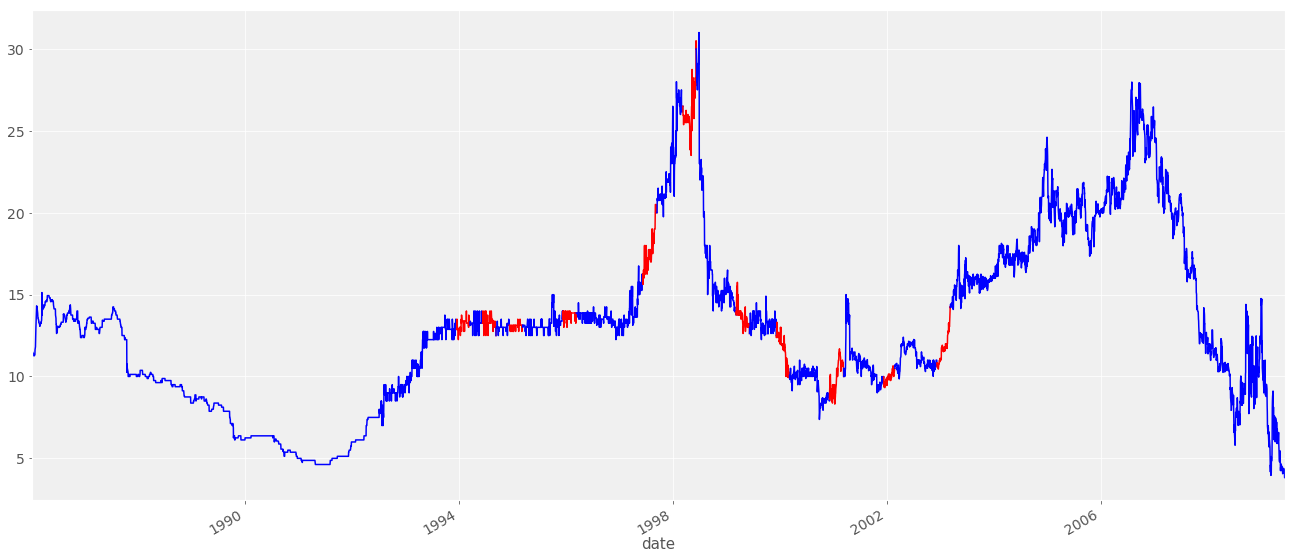

In [112]:
Dividend_Period_Plot(stock2, dividend2, increase=True)

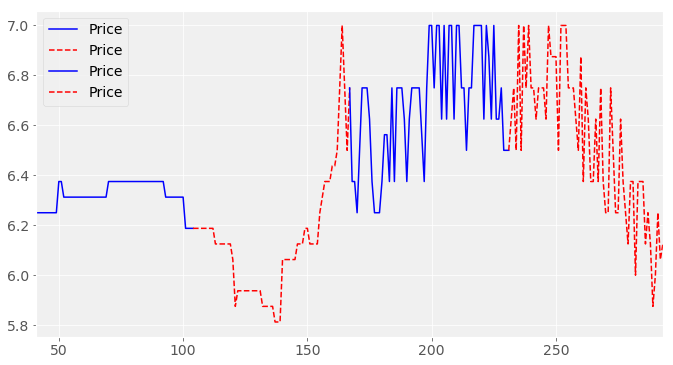

In [51]:
sample1 = stock.iloc[41:105]
#sample1 = sample1.reset_index(drop=True)
sample2 = stock.iloc[104:168]
#sample2 = sample2.reset_index(drop=True)
sample3 = stock.iloc[167:232]
sample4 = stock.iloc[231:294]
ax = sample1.plot(kind='line', y='Price', color='Blue', figsize=(10,6))
sample2.plot(kind='line', y='Price', color='Red', style='--', ax=ax)
sample3.plot(kind='line', y='Price', color='Blue', ax=ax)
sample4.plot(kind='line', y='Price', color='Red', style='--', ax=ax)

In [ ]:
def is_third_friday(s):
    d = datetime.datetime.strptime(str(s), '%Y%m%d')
    #d = datetime.strptime(s, '%b %d, %Y')
    return d.weekday() == 4 and 14 < d.day < 22

In [11]:
def Dividend_Increase_Events(df1, df2):
    # df1: daily prices
    # df2: dividend events
    company = []
    price_change = []
    dividend_change = []
    premium = []
    event_day = []
    frequence = []
    weight = []
    trimmed = []
    period = [0]
    N = len(df2.index)
    for i in tqdm(np.arange(1, N)):
        if i == 1 & df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]:
            date0 = datetime.datetime.strptime(str(df2['date'].iloc[0]), '%Y%m%d')
            key = df2['date'].iloc[0]
            index1 = df1[df1['key']==key].index[0] - 2
            index2 = df1[df1['key']==key].index[0] + 1
            first_day = datetime.datetime.strptime(str(df1[df1['PERMNO']==df2['PERMNO'].iloc[0]]['date'].iloc[0]), '%Y%m%d')
            gap = (date0-first_day).days
            # dividend initiations: first dividend over the last 6 quarters
            if abs(gap-540) <= 14:
                P1 = abs(df1.loc[index1]['PRC'])
                P2 = abs(df1.loc[index2]['PRC'])
                D0 = abs(df2['DIVAMT'].iloc[0])
                change = P2 - P1
                company.append(df2['PERMNO'].iloc[0])
                price_change.append(change)
                dividend_change.append(D0)
                event_day.append(df2['date'].iloc[0])
                #normalize initial premium to quarterly
                premium.append((change/D0) / (gap/90))
                frequence.append(0)
                weight.append((D2-D1)/P1)
                if (D2-D1)/abs(df1.loc[index1+1]['PRC']) < 0.00045:
                    trimmed.append(1)
                else:
                    trimmed.append(0)
            period = [0]

        elif df2['PERMNO'].iloc[i] != df2['PERMNO'].iloc[i-1]:
            date0 = datetime.datetime.strptime(str(df2['date'].iloc[i]), '%Y%m%d')
            key = df2['key'].iloc[i]
            index1 = df1[df1['key']==key].index[0] - 2
            index2 = df1[df1['key']==key].index[0] + 1
            first_day = datetime.datetime.strptime(str(df1[df1['PERMNO']==df2['PERMNO'].iloc[i]]['date'].iloc[0]), '%Y%m%d')
            gap = (date0-first_day).days
            # dividend initiations: first dividend over the last 6 quarters
            if abs(gap-540) <= 14:
                P1 = abs(df1.loc[index1]['PRC'])
                P2 = abs(df1.loc[index2]['PRC'])
                D0 = abs(df2['DIVAMT'].iloc[i])
                change = P2 - P1
                company.append(df2['PERMNO'].iloc[i])
                price_change.append(change)
                dividend_change.append(D0)
                event_day.append(df2['date'].iloc[i])
                #normalize initial premium to quarterly
                premium.append((change/D0) / (gap/91))
                frequence.append(0)
                weight.append((D2-D1)/P1)
                if (D2-D1)/abs(df1.loc[index1+1]['PRC']) < 0.00045:
                    trimmed.append(1)
                else:
                    trimmed.append(0)
            period = [0] 

        elif df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]:
            D1 = df2['DIVAMT'].iloc[i-1]
            D2 = df2['DIVAMT'].iloc[i]
            Price1 = abs(df2['PRC'].iloc[i-1])
            Price2 = abs(df2['PRC'].iloc[i])
            date1 = datetime.datetime.strptime(str(df2['date'].iloc[i-1]), '%Y%m%d')
            date2 = datetime.datetime.strptime(str(df2['date'].iloc[i]), '%Y%m%d')
            period.append((date2-date1).days)
            # discard the events with change in dividend yield of less than 0.001%
            # exclude a dividend event if its periodicity is different (beyound 14 days) from the previous
            if (D2 > D1) & ((D2/Price2 - D1/Price1) >= 0.00001):
                if abs(period[-1]-period[-2]) <= 14:
                    key = df2['key'].iloc[i]
                    index1 = df1[df1['key']==key].index[0] - 2
                    index2 = df1[df1['key']==key].index[0] + 1
                    P1 = abs(df1.loc[index1]['PRC'])
                    P2 = abs(df1.loc[index2]['PRC'])
                    change = P2 - P1
                    company.append(df2['PERMNO'].iloc[i])
                    price_change.append(change)
                    dividend_change.append(D2-D1)
                    event_day.append(df2['date'].iloc[i])
                    # normalize premiums to quarterly
                    premium.append((change/(D2-D1)) / (period[-1]/91))
                    frequence.append(period[-1]/91)
                    weight.append((D2-D1)/P1)
                    if (D2-D1)/abs(df1.loc[index1+1]['PRC']) < 0.00045:
                        trimmed.append(1)
                    else:
                        trimmed.append(0)
                        
    d = {'Event Date': event_day, 'PERMNO': company, 'Price Change': price_change, 'Dividend Change': dividend_change, 
         'Premium': premium, 'Frequence': frequence, 'Weight': weight, 'Trimmed': trimmed}
    print(len(event_day), len(price_change), len(dividend_change), len(premium), len(frequence), len(weight), len(trimmed))
    d = pd.DataFrame(d, columns=['Event Date', 'PERMNO', 'Price Change', 'Dividend Change', 'Premium', 'Frequence', 'Weight', 'Trimmed'])
    return d

In [13]:
table = Dividend_Increase_Events(merge1, DIVIDENDS)

100%|██████████| 56238/56238 [05:06<00:00, 183.29it/s]

5944 5944 5944 5944 5944 5944 5944


In [14]:
table.head()

,Event Date,PERMNO,Price Change,Dividend Change,Premium,Frequence,Weight,Trimmed
0,19890313,10001,-0.250000,0.010000,-23.214286,1.076923,0.001481,0
1,19900611,10001,0.250000,0.012500,20.000000,1.000000,0.001250,0
2,19910611,10001,0.000000,0.012500,0.000000,0.967033,0.001250,0
3,19920608,10001,-0.250000,0.007500,-33.333333,1.000000,0.000612,0
4,19940606,10001,0.125000,0.015000,8.333333,1.000000,0.000938,0


In [15]:
# dividend initiations
table[table['Frequence']==0]

,Event Date,PERMNO,Price Change,Dividend Change,Premium,Frequence,Weight,Trimmed
701,19880129,10569,0.750000,0.200000,0.639045,0.000000,0.000000,1
703,19880218,10580,-0.500000,0.060000,-1.373792,0.000000,0.000000,1
741,19880223,10607,-0.250000,0.100000,-0.415905,0.000000,0.000000,1
818,19880314,10665,1.000000,0.060000,2.782875,0.000000,0.000000,1
948,19880425,10780,-0.062500,0.050000,-0.206818,0.000000,0.000000,1
1057,19880518,10880,-0.250000,0.100000,-0.420518,0.000000,-0.020270,1
1595,19881220,11423,0.000000,0.120000,0.000000,0.000000,0.000000,1
1638,19881223,11488,0.000000,0.100000,0.000000,0.000000,-0.003418,1
1774,19890206,11603,-0.375000,0.100000,-0.628453,0.000000,0.000000,1
1810,19890222,11622,0.000000,0.027500,0.000000,0.000000,0.000000,1


In [16]:
table['Event Year'] = table['Event Date'].apply(lambda x: int(x/10000))
summary = table.groupby(['Event Year'])['Premium'].median()
summary = pd.DataFrame(summary)
summary.columns = ['Median Premium']
summary['# Events'] = table.groupby(['Event Year'])['Premium'].count()

In [17]:
summary

,Median Premium,# Events
Event Year,,
1977,-5.000000,89
1978,-7.541667,136
1979,-8.154122,155
1980,-8.654891,115
1981,-5.112360,101
1982,-7.916667,46
1983,-7.142857,55
1984,-3.956522,111
1985,0.000000,70


In [165]:
x = 19860813
time_x = datetime.datetime.strptime(str(x), '%Y%m%d')
y = 19880129
time_y = datetime.datetime.strptime(str(y), '%Y%m%d')
(time_y - time_x).days

534

In [28]:
def Dividend_Increase_Events2(df1, df2):
    # df1: daily prices
    # df2: dividend events
    company = []
    price_change = []
    dividend = []
    premium = []
    event_day = []
    frequence = []
    weight = []
    trimmed = []
    period = [0]
    N = len(df2.index)
    for i in tqdm(np.arange(1, N)):
        if i == 1 & df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]:
            date0 = datetime.datetime.strptime(str(df2['date'].iloc[0]), '%Y%m%d')
            key = df2['date'].iloc[0]
            index = df1[df1['key']==key].index[0] - 1
            first_day = datetime.datetime.strptime(str(df1[df1['PERMNO']==df2['PERMNO'].iloc[0]]['date'].iloc[0]), '%Y%m%d')
            gap = (date0-first_day).days
            # dividend initiations: first dividend over the last 6 quarters
            if abs(gap-540) <= 14:
                P1 = abs(df1.loc[index]['PRC'])
                P2 = abs(df2['PRC'].iloc[0])
                D0 = abs(df2['DIVAMT'].iloc[0])
                change = P2 - P1
                company.append(df2['PERMNO'].iloc[0])
                price_change.append(change)
                dividend.append(D0)
                event_day.append(df2['date'].iloc[0])
                #normalize initial premium to quarterly
                premium.append((-change/D0) / (gap/90))
                frequence.append(0)
                weight.append(D0/P2)
                if D0/P2 < 0.045:
                    trimmed.append(1)
                else:
                    trimmed.append(0)
            period = [0]

        elif df2['PERMNO'].iloc[i] != df2['PERMNO'].iloc[i-1]:
            date0 = datetime.datetime.strptime(str(df2['date'].iloc[i]), '%Y%m%d')
            key = df2['key'].iloc[i]
            index = df1[df1['key']==key].index[0] - 1
            first_day = datetime.datetime.strptime(str(df1[df1['PERMNO']==df2['PERMNO'].iloc[i]]['date'].iloc[0]), '%Y%m%d')
            gap = (date0-first_day).days
            # dividend initiations: first dividend over the last 6 quarters
            if abs(gap-540) <= 14:
                P1 = abs(df1.loc[index]['PRC'])
                P2 = abs(df2['PRC'].iloc[i])
                D0 = abs(df2['DIVAMT'].iloc[i])
                change = P2 - P1
                company.append(df2['PERMNO'].iloc[i])
                price_change.append(change)
                dividend.append(D0)
                event_day.append(df2['date'].iloc[i])
                #normalize initial premium to quarterly
                premium.append((-change/D0) / (gap/91))
                frequence.append(0)
                weight.append(D0/P2)
                if D0/P2 < 0.045:
                    trimmed.append(1)
                else:
                    trimmed.append(0)
            period = [0] 

        elif df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]:
            D1 = df2['DIVAMT'].iloc[i-1]
            D2 = df2['DIVAMT'].iloc[i]
            Price1 = abs(df2['PRC'].iloc[i-1])
            Price2 = abs(df2['PRC'].iloc[i])
            date1 = datetime.datetime.strptime(str(df2['date'].iloc[i-1]), '%Y%m%d')
            date2 = datetime.datetime.strptime(str(df2['date'].iloc[i]), '%Y%m%d')
            period.append((date2-date1).days)
            # discard the events with change in dividend yield of less than 0.001%
            # exclude a dividend event if its periodicity is different (beyound 14 days) from the previous
            if (D2 > D1) & ((D2/Price2 - D1/Price1) >= 0.00001):
                if abs(period[-1]-period[-2]) <= 14:
                    key = df2['key'].iloc[i]
                    index = df1[df1['key']==key].index[0] - 1
                    P1 = abs(df1.loc[index]['PRC'])
                    P2 = abs(df2['PRC'].iloc[i])
                    change = P2 - P1
                    company.append(df2['PERMNO'].iloc[i])
                    price_change.append(change)
                    dividend.append(D2)
                    event_day.append(df2['date'].iloc[i])
                    # normalize premiums to quarterly
                    premium.append((-change/D2) / (period[-1]/91))
                    frequence.append(period[-1]/91)
                    weight.append(D2/P2)
                    if D2/P2 < 0.045:
                        trimmed.append(1)
                    else:
                        trimmed.append(0)
                        
    d = {'Event Date': event_day, 'PERMNO': company, 'Price Change': price_change, 'Dividend': dividend, 
         'Premium': premium, 'Frequence': frequence, 'Weight': weight, 'Trimmed': trimmed}
    print(len(event_day), len(price_change), len(dividend), len(premium), len(frequence), len(weight), len(trimmed))
    d = pd.DataFrame(d, columns=['Event Date', 'PERMNO', 'Price Change', 'Dividend', 'Premium', 'Frequence', 'Weight', 'Trimmed'])
    return d

In [29]:
table2 = Dividend_Increase_Events2(merge1, DIVIDENDS)

100%|██████████| 56238/56238 [02:10<00:00, 431.55it/s]

5944 5944 5944 5944 5944 5944 5944


In [30]:
table2.head()

,Event Date,PERMNO,Price Change,Dividend,Premium,Frequence,Weight,Trimmed
0,19890313,10001,-0.375000,0.120000,2.901786,1.076923,0.018462,1
1,19900611,10001,0.000000,0.137500,-0.000000,1.000000,0.013750,1
2,19910611,10001,0.000000,0.150000,-0.000000,0.967033,0.015000,1
3,19920608,10001,0.250000,0.157500,-1.587302,1.000000,0.013125,1
4,19940606,10001,0.250000,0.190000,-1.315789,1.000000,0.011692,1


In [31]:
# dividend initiations
table2[table2['Frequence']==0]

,Event Date,PERMNO,Price Change,Dividend,Premium,Frequence,Weight,Trimmed
701,19880129,10569,0.000000,0.200000,-0.000000,0.000000,0.016495,1
703,19880218,10580,-0.250000,0.060000,0.686896,0.000000,0.006154,1
741,19880223,10607,0.750000,0.100000,-1.247715,0.000000,0.018182,1
818,19880314,10665,-1.000000,0.060000,2.782875,0.000000,0.005455,1
948,19880425,10780,0.000000,0.050000,-0.000000,0.000000,0.005970,1
1057,19880518,10880,-0.125000,0.100000,0.210259,0.000000,0.011111,1
1595,19881220,11423,0.000000,0.120000,-0.000000,0.000000,0.005333,1
1638,19881223,11488,-0.375000,0.100000,0.636660,0.000000,0.009091,1
1774,19890206,11603,0.250000,0.100000,-0.418969,0.000000,0.011429,1
1810,19890222,11622,0.000000,0.027500,-0.000000,0.000000,0.007333,1


In [32]:
table2['Event Year'] = table2['Event Date'].apply(lambda x: int(x/10000))
summary2 = table2.groupby(['Event Year'])['Premium'].median()
summary2 = pd.DataFrame(summary2)
summary2.columns = ['Median Premium']
summary2['# Events'] = table2.groupby(['Event Year'])['Premium'].count()

In [33]:
summary2

,Median Premium,# Events
Event Year,,
1977,0.899209,89
1978,0.912568,136
1979,1.002497,155
1980,1.000000,115
1981,1.034763,101
1982,0.959991,46
1983,0.595238,55
1984,0.833333,111
1985,0.323594,70


In [ ]:
# def Dividend_Increase_Events(df1, df2):
#     # df1: daily prices
#     # df2: dividend events
#     company = []
#     price_change = []
#     dividend_change = []
#     premium = []
#     event_day = []
#     frequence = []
#     period = [0]
#     N = len(df2.index)
#     for i in tqdm(np.arange(1, N)):
#         if i == 1 & df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]:
#             date0 = datetime.datetime.strptime(str(df2['date'].iloc[0]), '%Y%m%d')
#             key = df2['key'].iloc[0]
#             index = df1[df1['key']==key].index[0] - 1
#             first_day = datetime.datetime.strptime(str(df1[df1['PERMNO']==df2['PERMNO'].iloc[0]]['date'].iloc[0]), '%Y%m%d')
#             # dividend initiations: first dividend over the last 6 quarters
#             if abs((date0-first_day).days-540) <= 14:
#                 P0 = abs(df2['PRC'].iloc[0])
#                 D0 = abs(df2['DIVAMT'].iloc[0])
#                 change = P0-abs(df1.loc[index]['PRC'])
#                 company.append(df2['PERMNO'].iloc[0])
#                 price_change.append(change)
#                 dividend_change.append(D0)
#                 event_day.append(df2['date'].iloc[0])
#                 premium.append(-change / D0)
#                 frequence.append(0)

#         elif df2['PERMNO'].iloc[i] != df2['PERMNO'].iloc[i-1]:
#             date0 = datetime.datetime.strptime(str(df2['date'].iloc[i]), '%Y%m%d')
#             key = df2['key'].iloc[i]
#             index = df1[df1['key']==key].index[0] - 1
#             first_day = datetime.datetime.strptime(str(df1[df1['PERMNO']==df2['PERMNO'].iloc[i]]['date'].iloc[0]), '%Y%m%d')
#             # dividend initiations: first dividend over the last 6 quarters
#             if abs((date0-first_day).days-540) <= 14:
#                 P0 = abs(df2['PRC'].iloc[i])
#                 D0 = abs(df2['DIVAMT'].iloc[i])
#                 change = P0-abs(df1.loc[index]['PRC'])
#                 company.append(df2['PERMNO'].iloc[i])
#                 price_change.append(change)
#                 dividend_change.append(D0)
#                 event_day.append(df2['date'].iloc[i])
#                 premium.append(-change / D0)
#                 frequence.append(0)
#             period = [0] 

#         elif df2['PERMNO'].iloc[i] == df2['PERMNO'].iloc[i-1]:
#             D1 = df2['DIVAMT'].iloc[i-1]
#             D2 = df2['DIVAMT'].iloc[i]
#             P1 = abs(df2['PRC'].iloc[i-1])
#             P2 = abs(df2['PRC'].iloc[i])
#             date1 = datetime.datetime.strptime(str(df2['date'].iloc[i-1]), '%Y%m%d')
#             date2 = datetime.datetime.strptime(str(df2['date'].iloc[i]), '%Y%m%d')
#             period.append((date2-date1).days)
#             # discard the events with change in dividend yield of less than 0.1%
#             # exclude a dividend event if its periodicity is different (beyound 14 days) from the previous
#             if (D2 > D1) & ((D2/P2 - D1/P1) >= 0.001):
#                 if abs(period[-1]-period[-2]) <= 14:
#                     key = df2['key'].iloc[i]
#                     index = df1[df1['key']==key].index[0] - 1
#                     change = P2-abs(df1.loc[index]['PRC'])
#                     company.append(df2['PERMNO'].iloc[i])
#                     price_change.append(change)
#                     dividend_change.append(D2-D1)
#                     event_day.append(df2['date'].iloc[i])
#                     # normalize monthly premiums to quarterly
#                     if abs(period[-1]-30) <= 14:
#                         premium.append((-change / (D2-D1))*3)
#                         frequence.append(1)
#                     # quarterly premiums
#                     elif abs(period[-1]-90) <= 14:
#                         premium.append(-change / (D2-D1))
#                         frequence.append(1)
#                     # normalize semi-annual premiums to quarterly
#                     elif abs(period[-1]-180) <= 14:
#                         premium.append((-change / (D2-D1))/2)
#                         frequence.append(2)
#                     # normalize annual premiums to quarterly
#                     elif abs(period[-1]-360) <= 14:
#                         premium.append((-change / (D2-D1))/4)
#                         frequence.append(4)
#                     # normalize other premiums to quarterly
#                     elif abs(period[-1]-360) > 30:
#                         premium.append((-change/(D2-D1)) / (4*round(period[-1]/360,2)))
#                         frequence.append(4*round(period[-1]/360,2))
                        
#     d = {'Event Date': event_day, 'PERMNO': company, 'Price Change': price_change, 
#          'Dividend Change': dividend_change, 'Premium': premium, 'Frequence': frequence}
#     print(len(event_day), len(price_change), len(dividend_change), len(premium), len(frequence))
#     d = pd.DataFrame(d, columns=['Event Date', 'PERMNO', 'Price Change', 'Dividend Change', 'Premium', 'Frequence'])
#     return d